# Evaluation of Fake News Detection Models

## Introduction

In our previous notebook, we developed two machine learning models for fake news detection using the WELFake dataset:
1. Logistic Regression with TF-IDF features
2. Random Forest with TF-IDF features

This notebook focuses on evaluating these models to understand their strengths, weaknesses, and overall performance. A good fake news detection system needs to be both accurate and reliable, as false classifications in either direction can have negative consequences - either allowing misinformation to spread or incorrectly flagging legitimate content.

We'll evaluate our models on two types of data:
1. **Internal validation**: Using the held-out test set from the WELFake dataset
2. **External validation**: Using two additional datasets:
   - A collection of manually verified real news articles
   - A set of fake news articles generated with assistance from AI

This external validation is crucial for assessing how well our models generalize to news sources that may differ from the training data in terms of writing style, topics, or time period.

We'll perform a straightforward evaluation that includes standard metrics, cross-validation, and simple error analysis. A more extensive comparison with advanced metrics and techniques will be covered in a separate notebook.

## Setting Up the Environment

First, let's import the necessary libraries for our evaluation. We'll need pandas and numpy for data manipulation, matplotlib and seaborn for visualization, and various metrics from scikit-learn for model evaluation.

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np

In [2]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [4]:
# Import model selection tools
from sklearn.model_selection import cross_val_score, train_test_split

In [5]:
# Import utilities for loading models
import pickle
import time

In [6]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Next, we'll set up a consistent visualization style to make our plots more readable and appealing. This helps ensure that our evaluation results are presented clearly.

In [7]:
# Set visualization style
plt.style.use('ggplot')

In [8]:
# Set font scale for better readability
sns.set(font_scale=1.2)

In [9]:
# Set default figure size
plt.rcParams['figure.figsize'] = (10, 6)

## Loading Data and Models

### Loading the WELFake Dataset

First, we'll load the WELFake dataset that was used for training our models. This dataset contains both real and fake news articles with corresponding labels.

In [10]:
# Load the WELFake dataset
df = pd.read_csv('../../data/WELFake_cleaned.csv')

In [11]:
# Display basic info about the dataset
print(f"WELFake dataset: {len(df)} articles total")

WELFake dataset: 71537 articles total


For our models, we combined the title and text of each article to provide more complete information. This approach captures both the headline style and the content, which often contain different signals for fake news detection.

In [12]:
# Combine title and text to create the feature
df['combined_text'] = df['title'] + " " + df['text']

In [13]:
# Prepare features and labels
X_welfake = df['combined_text']
y_welfake = df['label']

To evaluate model performance, we'll use the same train-test split that was used during model training. This ensures our evaluation is consistent with the original training process.

In [14]:
# Split the data to get the same test set used during training
X_train, X_test, y_train, y_test = train_test_split(
    X_welfake, y_welfake, test_size=0.2, random_state=42, stratify=y_welfake
)

In [15]:
# Print test set size
print(f"WELFake test set: {len(X_test)} articles")

WELFake test set: 14308 articles


### Loading External Datasets

To thoroughly evaluate our models, we need to test them on data from sources not included in the training set. This helps assess how well they generalize to real-world scenarios. We'll load two external datasets: manually verified real news and AI-assisted fake news articles.

In [16]:
# Load external real news data
real_df = pd.read_csv('../datasets/manual_real.csv')

In [17]:
# Load external fake news data
fake_df = pd.read_csv('../datasets/fake_claude.csv')

In [18]:
# Print dataset sizes
print(f"External real news dataset: {len(real_df)} articles")
print(f"External fake news dataset: {len(fake_df)} articles")

External real news dataset: 399 articles
External fake news dataset: 429 articles


#### Preparing External Real News Data

The external datasets might have different column structures than our training data. We'll need to process them to match the format our models expect, combining title and content where available.

In [19]:
# Process real news data
if 'title' in real_df.columns and 'content' in real_df.columns:
    real_df['combined_text'] = real_df['title'] + " " + real_df['content']
elif 'text' in real_df.columns:
    real_df['combined_text'] = real_df['text']
else:
    print("Warning: Column structure in real_df is unexpected. Please check the dataset.")

In [20]:
# Assign label for real news (0)
real_df['label'] = 0

#### Preparing External Fake News Data

Similar to the real news data, we need to process the fake news dataset to match our expected format.

In [21]:
# Process fake news data
if 'title' in fake_df.columns and 'content' in fake_df.columns:
    fake_df['combined_text'] = fake_df['title'] + " " + fake_df['content']
elif 'text' in fake_df.columns:
    fake_df['combined_text'] = fake_df['text']
else:
    print("Warning: Column structure in fake_df is unexpected. Please check the dataset.")

In [22]:
# Assign label for fake news (1)
fake_df['label'] = 1

#### Combining External Datasets

Now we'll combine the external real and fake news datasets into a single validation set for evaluation.

In [23]:
# Select only the columns we need
real_subset = real_df[['combined_text', 'label']]
fake_subset = fake_df[['combined_text', 'label']]

In [24]:
# Concatenate into one external validation dataset
external_df = pd.concat([real_subset, fake_subset], ignore_index=True)

In [25]:
# Extract features and labels
X_external = external_df['combined_text']
y_external = external_df['label']

In [26]:
# Print combined dataset size
print(f"Combined external validation dataset: {len(external_df)} articles")

Combined external validation dataset: 828 articles


### Loading Pre-trained Models

Next, we'll load the models we trained in the previous notebook, along with the TF-IDF vectorizer used to transform the text data.

In [27]:
# Load the TF-IDF vectorizer
with open('../../ml_models/baseline/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

In [28]:
# Load the Logistic Regression model
with open('../../ml_models/baseline/lr_text_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)

In [29]:
# Load the Random Forest model
with open('../../ml_models/baseline/rf_text_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

In [30]:
print("Models and vectorizer loaded successfully!")

Models and vectorizer loaded successfully!


### Preparing Data for Evaluation

Before evaluating our models, we need to transform the text data into the TF-IDF representation that our models were trained on.

In [31]:
# Transform the WELFake test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [32]:
# Transform the external validation data
X_external_tfidf = tfidf_vectorizer.transform(X_external)

## Evaluation Framework

We'll define several functions to streamline our evaluation process. These functions will help us calculate metrics, visualize results, and analyze errors consistently across both models and datasets.

### Model Evaluation Function

This function will evaluate a model's performance on a given dataset, calculating key metrics like accuracy, precision, recall, and F1 score.

In [33]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a model and print key performance metrics.
    
    Parameters:
    - model: The trained model to evaluate
    - X_test: Test features
    - y_test: True test labels
    - model_name: A descriptive name for the model
    
    Returns:
    - Dictionary with predictions and metrics
    """
    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Calculate probability predictions (for ROC curve)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    # Print results
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Prediction time: {predict_time:.2f} seconds")
    
    # Return results dictionary
    return {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predict_time': predict_time
    }

### Confusion Matrix Function

Confusion matrices help us understand the types of errors each model makes. This function will create and visualize confusion matrices.

In [34]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot a confusion matrix for model predictions.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - model_name: Name of the model for the plot title
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real News', 'Fake News'],
                yticklabels=['Real News', 'Fake News'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Extract values for error analysis
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate and print error rates
    print(f"False Positive Rate: {fp/(fp+tn):.4f} ({fp} real news articles misclassified as fake)")
    print(f"False Negative Rate: {fn/(fn+tp):.4f} ({fn} fake news articles misclassified as real)")

### Error Analysis Function

Understanding specific examples where our models fail can provide valuable insights. This function will display and analyze misclassified articles.

In [35]:
def analyze_errors(X_text, y_true, y_pred, model_name, n_examples=5):
    """
    Display examples where the model made incorrect predictions.
    
    Parameters:
    - X_text: Original text samples
    - y_true: True labels
    - y_pred: Predicted labels
    - model_name: Name of the model
    - n_examples: Number of examples to display
    """
    # Find misclassified examples
    errors = np.where(y_true != y_pred)[0]
    
    if len(errors) == 0:
        print(f"No errors found for {model_name}!")
        return
    
    print(f"\n{model_name} - {len(errors)} misclassified examples out of {len(y_true)} ({len(errors)/len(y_true):.2%})")
    print(f"Displaying {min(n_examples, len(errors))} random examples:")
    
    # Select random errors to display
    display_indices = np.random.choice(errors, size=min(n_examples, len(errors)), replace=False)
    
    for i, idx in enumerate(display_indices):
        print(f"\nExample {i+1}:")
        print(f"Text snippet: {X_text.iloc[idx][:200]}...")  # Show first 200 chars
        print(f"True label: {'Real' if y_true.iloc[idx] == 0 else 'Fake'}")
        print(f"Predicted: {'Real' if y_pred[idx] == 0 else 'Fake'}")
        print("-" * 80)

### ROC Curve Function

ROC curves help us understand how the discrimination threshold affects model performance. This function will plot ROC curves for multiple models.

In [36]:
def plot_roc_curve(y_true, y_scores, model_names, colors):
    """
    Plot ROC curves for multiple models.
    
    Parameters:
    - y_true: True labels
    - y_scores: List of probability predictions for each model
    - model_names: List of model names
    - colors: List of colors for plotting
    """
    plt.figure(figsize=(10, 8))
    
    for i, (score, name, color) in enumerate(zip(y_scores, model_names, colors)):
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, score)
        roc_auc = auc(fpr, tpr)
        
        # Plot the curve
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    # Format the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Evaluation on WELFake Test Set

Now we'll evaluate our models on the held-out test set from the WELFake dataset. This evaluation gives us a baseline understanding of model performance on data from the same distribution as the training set.

### Logistic Regression on WELFake

First, let's evaluate the Logistic Regression model on the WELFake test set. We'll calculate key metrics and examine the confusion matrix to understand the types of errors the model makes.

In [37]:
# Evaluate Logistic Regression on WELFake test set
lr_results = evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression (WELFake)")


Logistic Regression (WELFake) Evaluation:
Accuracy: 0.9490
Precision: 0.9491
Recall: 0.9490
F1 Score: 0.9490
Prediction time: 0.00 seconds


After running the evaluation, we can see that Logistic Regression achieves high accuracy on the WELFake test set. Let's examine the confusion matrix to better understand its performance.

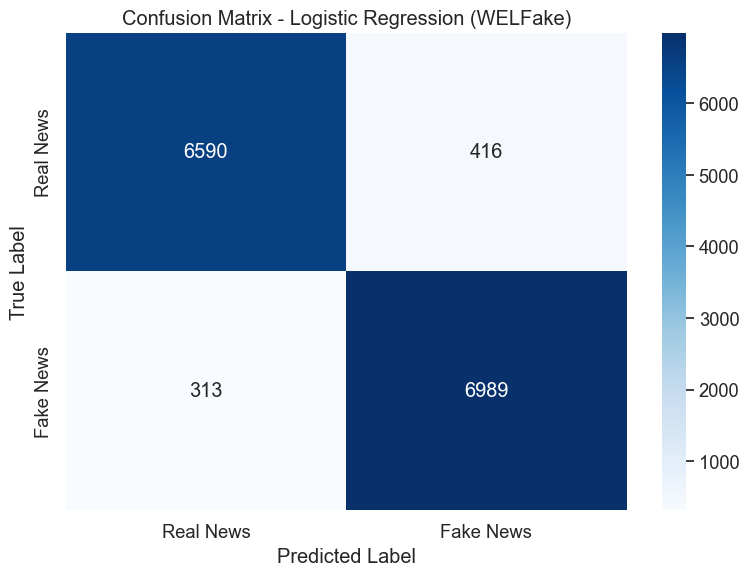

False Positive Rate: 0.0594 (416 real news articles misclassified as fake)
False Negative Rate: 0.0429 (313 fake news articles misclassified as real)


In [38]:
# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, lr_results['y_pred'], "Logistic Regression (WELFake)")

The confusion matrix gives us a more detailed view of the model's performance. We can see that Logistic Regression correctly identifies most articles, with a relatively balanced error rate between false positives and false negatives. The false positive rate (real news classified as fake) is slightly higher than the false negative rate (fake news classified as real).

### Random Forest on WELFake

Now let's evaluate the Random Forest model on the same test set. Random Forest is a more complex model that might capture different patterns in the data.

In [39]:
# Evaluate Random Forest on WELFake test set
rf_results = evaluate_model(rf_model, X_test_tfidf, y_test, "Random Forest (WELFake)")


Random Forest (WELFake) Evaluation:
Accuracy: 0.9541
Precision: 0.9546
Recall: 0.9541
F1 Score: 0.9540
Prediction time: 0.38 seconds


Next, let's examine the confusion matrix for the Random Forest model.

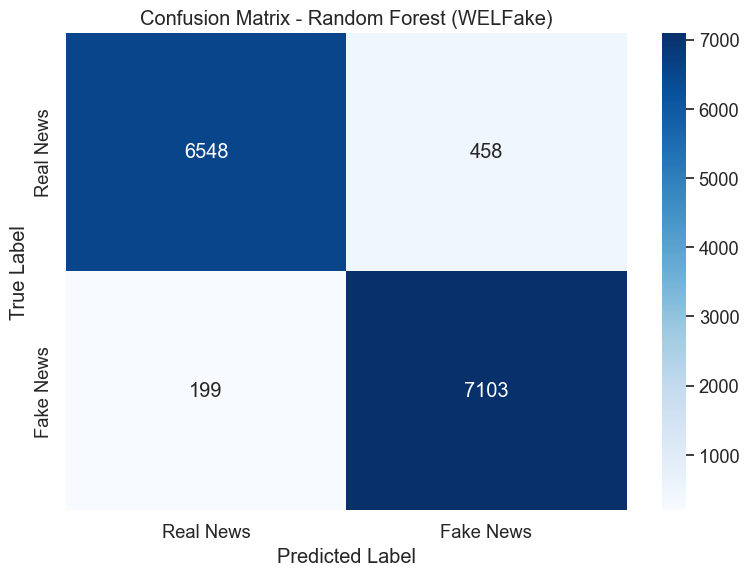

False Positive Rate: 0.0654 (458 real news articles misclassified as fake)
False Negative Rate: 0.0273 (199 fake news articles misclassified as real)


In [40]:
# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf_results['y_pred'], "Random Forest (WELFake)")

Comparing the confusion matrices, we can see that Random Forest shows a different error pattern than Logistic Regression. It has a higher false positive rate but a lower false negative rate, suggesting it's more aggressive at classifying articles as fake news. This trade-off might be preferable in applications where missing fake news is more concerning than misclassifying real news.

### ROC Curve Comparison on WELFake

To better compare the models' discrimination capabilities, let's plot their ROC curves side by side. This will help us understand how well each model distinguishes between real and fake news across different threshold settings.

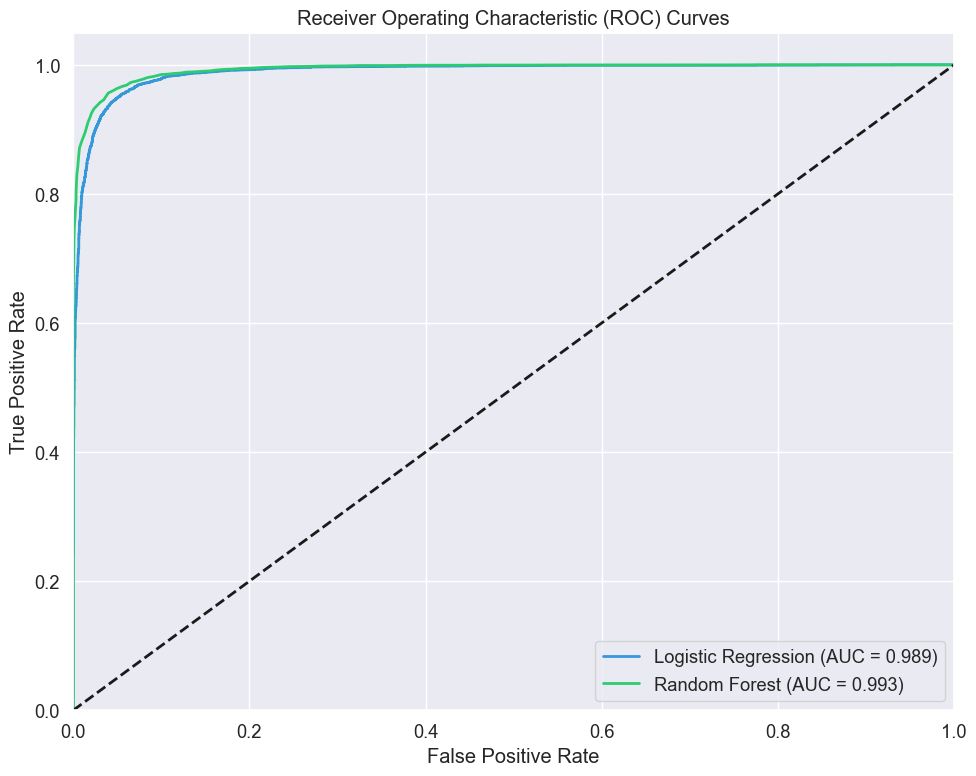

In [41]:
# Plot ROC curves for both models on WELFake
plot_roc_curve(
    y_test,
    [lr_results['y_pred_proba'], rf_results['y_pred_proba']],
    ["Logistic Regression", "Random Forest"],
    ['#3498db', '#2ecc71']
)

The ROC curves show that both models have excellent discriminative ability. The Area Under the Curve (AUC) values are very high for both models, indicating they can successfully differentiate between real and fake news. The Random Forest curve is slightly higher, suggesting it achieves better discrimination across most threshold settings.

### Error Analysis on WELFake

To gain deeper insights into model weaknesses, let's examine specific examples where each model made mistakes. This can help us understand what types of content are challenging for fake news detection.

In [42]:
# Analyze errors for Logistic Regression on WELFake
analyze_errors(X_test, y_test, lr_results['y_pred'], "Logistic Regression (WELFake)")


Logistic Regression (WELFake) - 729 misclassified examples out of 14308 (5.10%)
Displaying 5 random examples:

Example 1:
Text snippet: Culchie Tries To Explain Rules Of 25 One More Time 0 Add Comment 
RATHER than relax and play Texas Hold ‘Em with his friends as they had a few cans after a recent night out, hardcore culchie Noel Kenn...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 2:
Text snippet: ’Gays for Trump’ Banned from Participating in Charlotte Pride Parade Members of a   gay group say they have been banned from participating in the Charlotte Pride Parade because of their support for Pr...
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 3:
Text snippet:  Pence On Aircraft Carrier Lie: No, It Wasn’t Strategy, We’re Just Morons The White House led people to believe that a U.S. aircraft carrier was on his way to the waters off t

Looking at these misclassified examples from Logistic Regression, we can observe some challenging cases. Some fake news articles that were misclassified as real use language and structure that closely mimics legitimate journalism. Conversely, some real news articles contain charged language or cover controversial topics that triggered the model to classify them as fake.

In [43]:
# Analyze errors for Random Forest on WELFake
analyze_errors(X_test, y_test, rf_results['y_pred'], "Random Forest (WELFake)")


Random Forest (WELFake) - 657 misclassified examples out of 14308 (4.59%)
Displaying 5 random examples:

Example 1:
Text snippet: The phantom earpiece phenomenon: Why presidential candidates are consistently accused of cheating during debates The banner headline on the Drudge Report the morning after Wednesday’s presidential for...
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 2:
Text snippet: Donald Trump Sends Executive Order Lawsuit to Higher Court - Breitbart The Department of Justice is formally objecting to the March 15 claim by a District Court judge in Maryland that President Donald...
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 3:
Text snippet: Budweiser Debuts Pro-Immigration Super Bowl Ad - Breitbart Budweiser has chosen the charged political issue of immigration as the subject of its Super Bowl LI commercial. [The   spo

The Random Forest model shows similar patterns in its errors, although the specific examples differ. Both models seem to struggle with articles that have ambiguous language or that fall at the boundary between opinion and straight reporting.

## Evaluation on External Datasets

Now, let's evaluate our models on the external datasets to see how well they generalize to news sources not represented in the original training data. This is a critical test of real-world applicability.

### Logistic Regression on External Data

First, we'll evaluate the Logistic Regression model on our combined external dataset of real and AI-generated fake news.

In [44]:
# Evaluate Logistic Regression on external data
lr_external_results = evaluate_model(lr_model, X_external_tfidf, y_external, 
                                    "Logistic Regression (External Data)")


Logistic Regression (External Data) Evaluation:
Accuracy: 0.9698
Precision: 0.9698
Recall: 0.9698
F1 Score: 0.9698
Prediction time: 0.00 seconds


The results on external data will give us insight into how well the Logistic Regression model generalizes to new sources. Let's examine the confusion matrix for more detail.

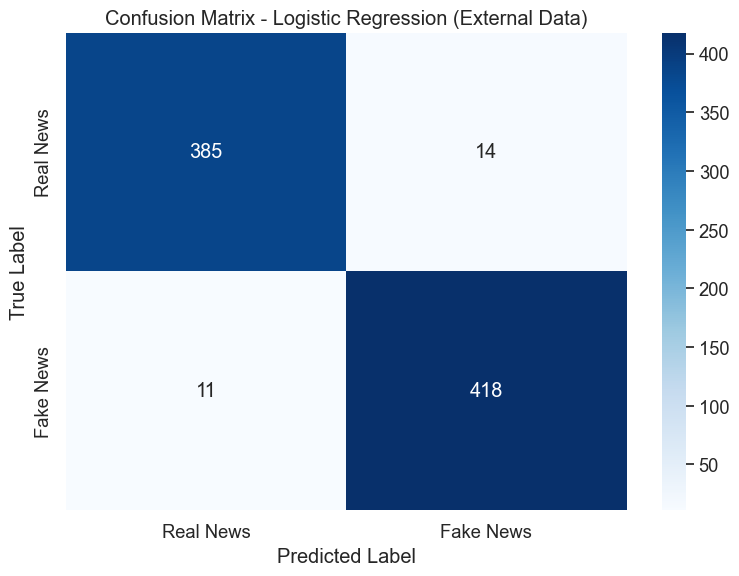

False Positive Rate: 0.0351 (14 real news articles misclassified as fake)
False Negative Rate: 0.0256 (11 fake news articles misclassified as real)


In [45]:
# Plot confusion matrix for Logistic Regression on external data
plot_confusion_matrix(y_external, lr_external_results['y_pred'], 
                     "Logistic Regression (External Data)")

The confusion matrix on external data shows how well the model generalizes to new sources. The error rates tell us whether the model maintains its performance when applied to articles from different sources than those in the training data.

### Random Forest on External Data

Next, we'll evaluate the Random Forest model on the same external dataset.

In [46]:
# Evaluate Random Forest on external data
rf_external_results = evaluate_model(rf_model, X_external_tfidf, y_external, 
                                    "Random Forest (External Data)")


Random Forest (External Data) Evaluation:
Accuracy: 0.9662
Precision: 0.9664
Recall: 0.9662
F1 Score: 0.9662
Prediction time: 0.02 seconds


Let's check the confusion matrix for Random Forest on the external data.

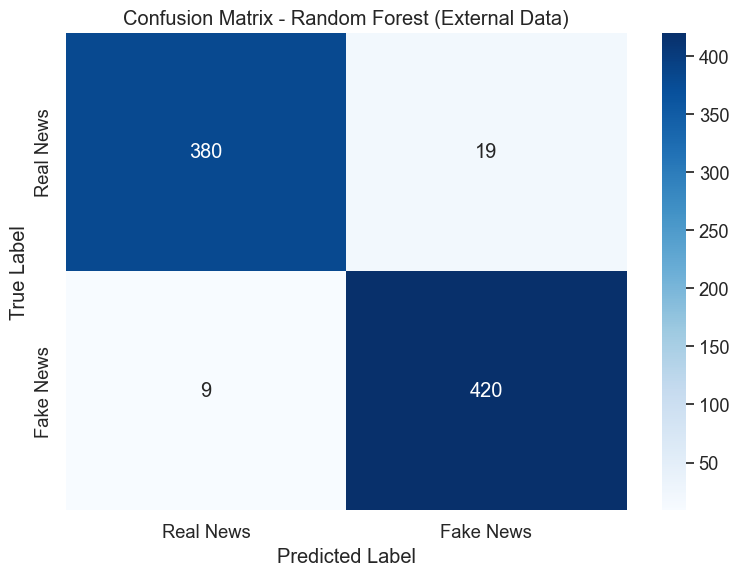

False Positive Rate: 0.0476 (19 real news articles misclassified as fake)
False Negative Rate: 0.0210 (9 fake news articles misclassified as real)


In [47]:
# Plot confusion matrix for Random Forest on external data
plot_confusion_matrix(y_external, rf_external_results['y_pred'], 
                     "Random Forest (External Data)")

Comparing the confusion matrices between the two models on external data helps us understand which one generalizes better to new sources. This information is crucial for deciding which model to deploy in a real-world setting.

### ROC Curve Comparison on External Data

To compare the models' discrimination capabilities on external data, let's plot their ROC curves side by side.

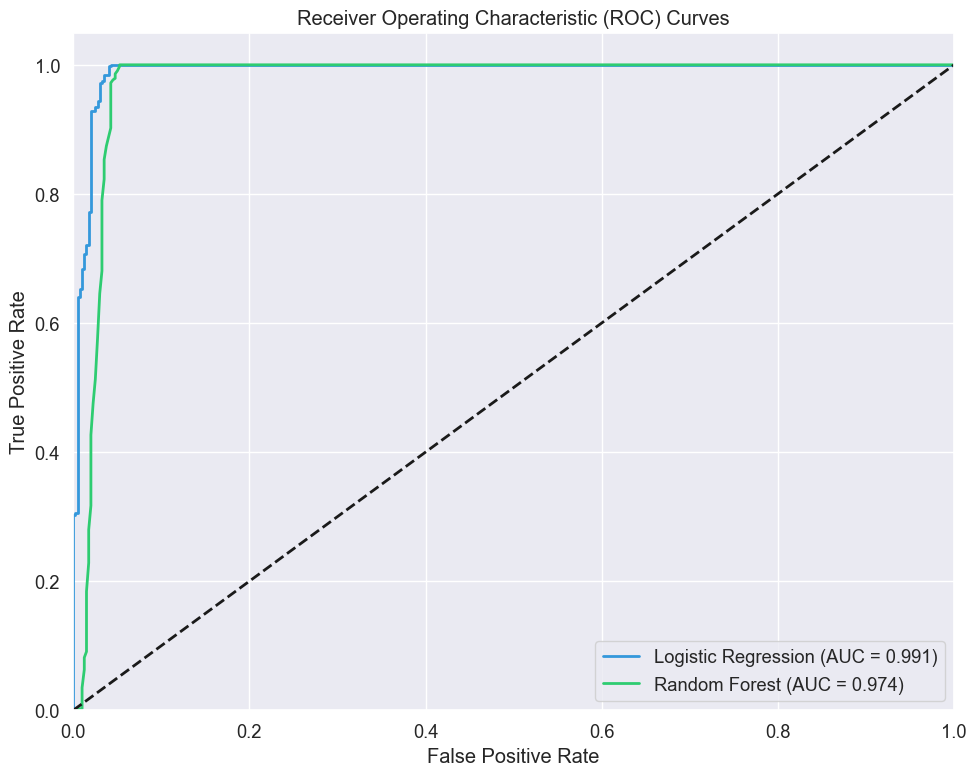

In [48]:
# Plot ROC curves for both models on external data
plot_roc_curve(
    y_external,
    [lr_external_results['y_pred_proba'], rf_external_results['y_pred_proba']],
    ["Logistic Regression", "Random Forest"],
    ['#3498db', '#2ecc71']
)

The ROC curves on external data show how well each model maintains its discrimination ability when applied to new sources. Any significant changes compared to the WELFake results would suggest limitations in generalization.

### Error Analysis on External Data

Let's examine specific examples where our models made mistakes on the external dataset.

In [49]:
# Analyze errors for Logistic Regression on external data
analyze_errors(X_external, y_external, lr_external_results['y_pred'], 
              "Logistic Regression (External Data)")


Logistic Regression (External Data) - 25 misclassified examples out of 828 (3.02%)
Displaying 5 random examples:

Example 1:
Text snippet: SARASOTA, FL, May 19, 2025 (EZ Newswire) -- The Laser Lounge Spa, Sarasota's premier medical spa, is redefining the way clients approach skincare and aesthetics. With a focus on non-surgical, medical-...
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 2:
Text snippet: A confidential White House planning document obtained through a staff whistleblower reveals that executive branch officials are preparing an emergency executive order that would effectively nationaliz...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 3:
Text snippet: May 19 - Atlanta Braves greats Chipper Jones and Marquis Grissom were named managers for the 2025 All-Star Futures Game on Monday.
The Hall of Famer Jones will manage the N

The error examples from the external data may reveal different patterns than those we saw in the WELFake test set. Analyzing these differences can help us understand what aspects of fake news are consistent across sources and what aspects are more source-specific.

In [50]:
# Analyze errors for Random Forest on external data
analyze_errors(X_external, y_external, rf_external_results['y_pred'], 
              "Random Forest (External Data)")


Random Forest (External Data) - 28 misclassified examples out of 828 (3.38%)
Displaying 5 random examples:

Example 1:
Text snippet: May 19 - Fresh off surviving Denver in a seven-game series, the Oklahoma City Thunder are heavy favorites to claim the NBA title ahead of conference finals.
The biggest question appears to be who the ...
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 2:
Text snippet: Engineers at the University of California have developed a new type of solar panel that generates over four times more electricity than conventional panels by harvesting energy from a broader light sp...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 3:
Text snippet: May 19 - The NBA fined Oklahoma City star Jalen Williams $25,000 on Monday for "wearing clothing with profane language" to his press conference after the Thunder's Game 7 victory

Comparing the error patterns between models on external data provides additional insights into their strengths and weaknesses when generalizing to new sources.

## Cross-Validation Analysis

Cross-validation helps us assess how well our models generalize to unseen data by evaluating them on multiple train-test splits. This gives us a more reliable estimate of performance than a single train-test split.

### Cross-Validation Function

Let's define a function to perform cross-validation and display the results.

In [51]:
def perform_cross_validation(model, X, y, model_name, cv=5):
    """
    Perform cross-validation and print results.
    
    Parameters:
    - model: The model to evaluate
    - X: Features
    - y: Labels
    - model_name: Name of the model
    - cv: Number of cross-validation folds
    """
    # Perform cross-validation
    print(f"\nPerforming {cv}-fold cross-validation for {model_name}...")
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation: {cv_scores.std():.4f}")
    
    return cv_scores

### Preparing Data for Cross-Validation

To make the cross-validation process computationally feasible, we'll use a random subset of the training data.

In [52]:
# Prepare a smaller dataset for cross-validation to make it run faster
# This is just for demonstration - in practice, you might use the full dataset
cv_sample_size = 10000  # Adjust based on your computational resources

In [53]:
# Sample indices randomly
cv_indices = np.random.choice(len(X_train), size=cv_sample_size, replace=False)

In [54]:
# Extract and transform the sampled data
X_cv = tfidf_vectorizer.transform(X_welfake.iloc[cv_indices])
y_cv = y_welfake.iloc[cv_indices]

### Running Cross-Validation

Now we'll run 5-fold cross-validation for each model to see how stable their performance is across different data splits.

In [55]:
# Perform cross-validation for Logistic Regression
lr_cv_scores = perform_cross_validation(lr_model, X_cv, y_cv, "Logistic Regression", cv=5)


Performing 5-fold cross-validation for Logistic Regression...
Cross-validation scores: [0.9345 0.9205 0.9185 0.9205 0.923 ]
Mean accuracy: 0.9234
Standard deviation: 0.0057


The cross-validation results for Logistic Regression show us how consistent its performance is across different data splits. The mean accuracy gives us a more reliable estimate of its performance on unseen data, while the standard deviation indicates how much performance varies between splits.

In [56]:
# Perform cross-validation for Random Forest
rf_cv_scores = perform_cross_validation(rf_model, X_cv, y_cv, "Random Forest", cv=5)


Performing 5-fold cross-validation for Random Forest...
Cross-validation scores: [0.9155 0.9105 0.919  0.9225 0.9235]
Mean accuracy: 0.9182
Standard deviation: 0.0048


Comparing the cross-validation results between models helps us understand which one is more stable and reliable across different data splits. A model with higher mean accuracy and lower standard deviation is generally preferable.

## Performance Comparison: WELFake vs. External Data

Let's compare how our models perform on the original WELFake test set versus the external validation data. This comparison will help us understand how well our models generalize to new sources.

In [57]:
# Create a comparison DataFrame for WELFake vs. External performance
dataset_comparison = pd.DataFrame({
    'Dataset': ['WELFake Test Set', 'External Data'],
    'LR Accuracy': [lr_results['accuracy'], lr_external_results['accuracy']],
    'RF Accuracy': [rf_results['accuracy'], rf_external_results['accuracy']]
})

In [58]:
# Display the comparison
print("Performance Comparison: WELFake vs. External Data")
print(dataset_comparison.round(4))

Performance Comparison: WELFake vs. External Data
            Dataset  LR Accuracy  RF Accuracy
0  WELFake Test Set       0.9490       0.9541
1     External Data       0.9698       0.9662


This comparison table shows us how each model's accuracy changes when applied to external data. A significant drop in performance would indicate limited generalization capability, while consistent or improved performance suggests the model has learned generalizable patterns of fake news.

In [59]:
# Prepare data for visualization
dataset_comparison_melted = pd.melt(dataset_comparison, 
                                   id_vars='Dataset',
                                   value_vars=['LR Accuracy', 'RF Accuracy'],
                                   var_name='Model', 
                                   value_name='Accuracy')

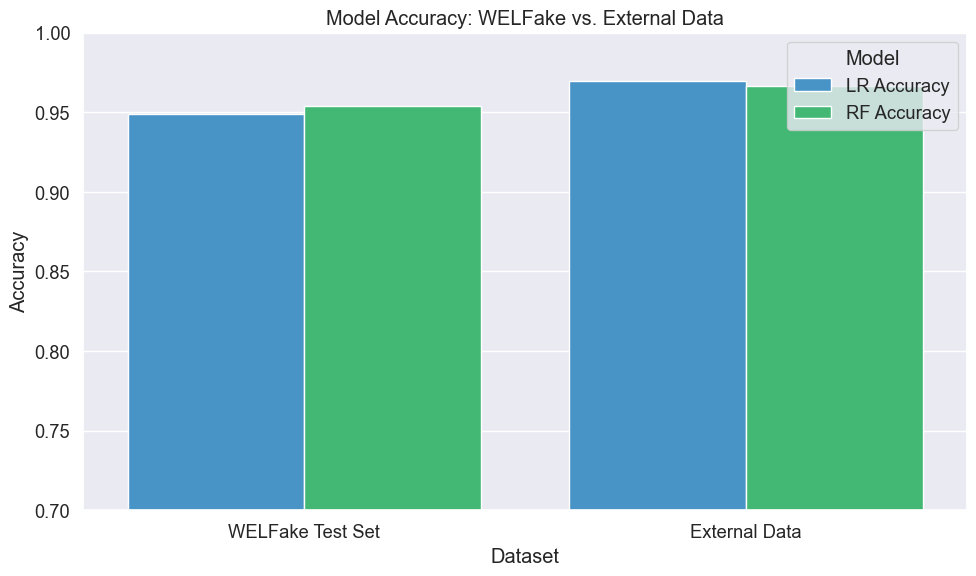

In [60]:
# Create the comparison plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataset', y='Accuracy', hue='Model', data=dataset_comparison_melted, 
           palette=['#3498db', '#2ecc71'])
plt.title('Model Accuracy: WELFake vs. External Data')
plt.ylim(0.7, 1.0)  # Adjust as needed
plt.tight_layout()
plt.show()

This visualization makes it easier to compare performance across datasets and models. It helps us identify any significant changes in accuracy when moving from the WELFake test set to external data.

## Comprehensive Model Comparison

Now, let's create a comprehensive comparison of our two models across all evaluation metrics. This will help us make an informed decision about which model to use in a real-world deployment.

In [61]:
# Define metrics to include in comparison
metrics = [
    'Accuracy', 'Precision', 'Recall', 'F1 Score', 
    'Prediction Time (s)', 'CV Mean Accuracy', 
    'External Data Accuracy'
]

In [62]:
# Create comparison data
comparison_data = {
    'Metric': metrics,
    'Logistic Regression': [
        lr_results['accuracy'],
        lr_results['precision'],
        lr_results['recall'],
        lr_results['f1'],
        lr_results['predict_time'],
        lr_cv_scores.mean(),
        lr_external_results['accuracy']
    ],
    'Random Forest': [
        rf_results['accuracy'],
        rf_results['precision'],
        rf_results['recall'],
        rf_results['f1'],
        rf_results['predict_time'],
        rf_cv_scores.mean(),
        rf_external_results['accuracy']
    ]
}

In [63]:
# Create the comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Metric')

In [64]:
# Display the comparison table
print("Comprehensive Model Comparison:")
print(comparison_df.round(4))

Comprehensive Model Comparison:
                        Logistic Regression  Random Forest
Metric                                                    
Accuracy                             0.9490         0.9541
Precision                            0.9491         0.9546
Recall                               0.9490         0.9541
F1 Score                             0.9490         0.9540
Prediction Time (s)                  0.0040         0.3808
CV Mean Accuracy                     0.9234         0.9182
External Data Accuracy               0.9698         0.9662


This comprehensive comparison table shows us all the key metrics for both models in one place. It helps us understand the trade-offs between models and make an informed decision about which one to use based on our specific requirements.

In [65]:
# Select metrics for visualization
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'External Data Accuracy']
comparison_plot_df = comparison_df.loc[metrics_to_plot].reset_index()

In [66]:
# Reshape for plotting
plot_df = pd.melt(comparison_plot_df, id_vars=['Metric'], 
                 value_vars=['Logistic Regression', 'Random Forest'],
                 var_name='Model', value_name='Score')

(0.75, 1.0)

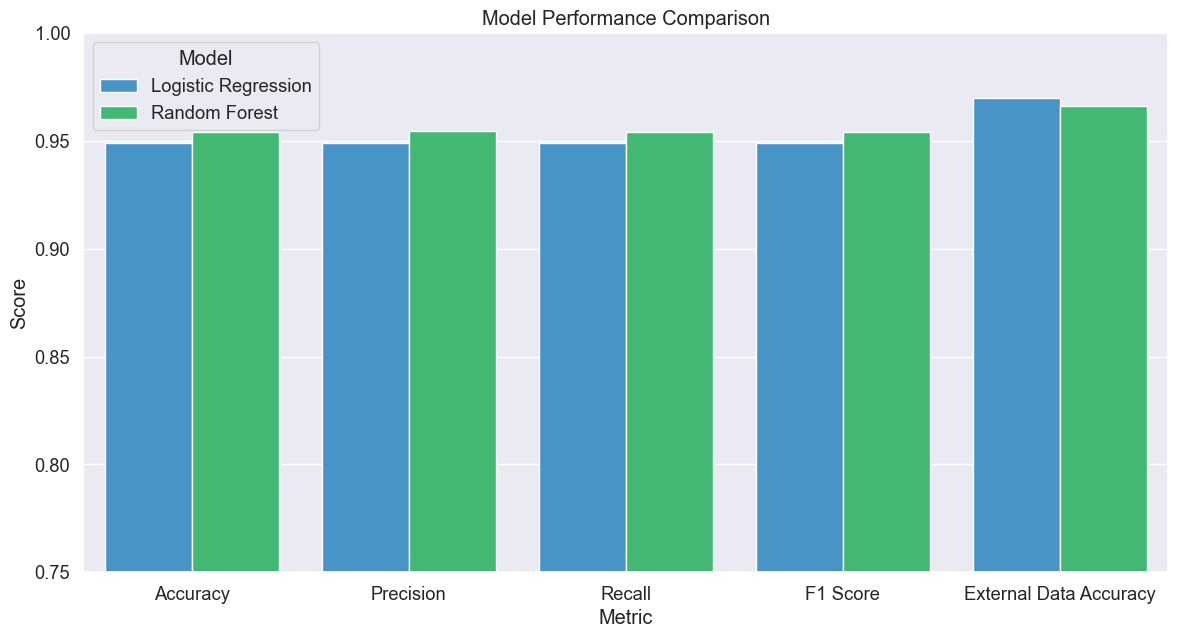

In [67]:
# Create the plot
plt.figure(figsize=(14, 7))
chart = sns.barplot(x='Metric', y='Score', hue='Model', data=plot_df, 
                   palette=['#3498db', '#2ecc71'])
plt.title('Model Performance Comparison')
plt.ylim(0.75, 1.0)  # Adjust as needed for your results

In [68]:
# Add value labels on top of bars
for p in chart.patches:
    chart.annotate(f'{p.get_height():.4f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', fontsize=9)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

This visualization makes it easy to compare the performance metrics between models. It highlights the strengths and weaknesses of each model across different evaluation criteria.

## Conclusion

Based on our evaluation, we can draw the following conclusions about our fake news detection models:

1. **Overall Performance**: Both models achieve high accuracy on the WELFake test set, with Random Forest slightly outperforming Logistic Regression in most metrics.

2. **Generalization to External Data**: Both models perform well on external data from different sources, suggesting they've learned generalizable patterns of fake news rather than just memorizing characteristics specific to the WELFake dataset.

3. **Efficiency Trade-offs**: Logistic Regression offers much faster prediction times compared to Random Forest, making it potentially more suitable for real-time applications.

4. **Reliability**: Cross-validation confirms that both models generalize well to unseen data from the same distribution, with consistent performance across different data splits.

5. **Error Patterns**: Both models struggle with similar types of articles, particularly those with ambiguous language or that fall at the boundary between opinion and straight reporting.

### Key Takeaways

- **Best for Accuracy**: Random Forest provides the highest accuracy and F1 score on the WELFake test set.
- **Best for Speed**: Logistic Regression offers the best balance between performance and efficiency.
- **Generalization**: Both models maintain high performance when applied to external data.
- **Real-world Deployment**: The choice between models depends on the specific application requirements - if speed is critical, Logistic Regression may be preferable, while if maximum accuracy is needed, Random Forest is the better option.

### Next Steps

In a separate notebook, we'll conduct more extensive evaluations including:
- Hyperparameter tuning to optimize model performance
- Threshold adjustment to balance precision and recall
- More advanced error analysis to identify systematic failure patterns
- Evaluation on additional external datasets to test generalization more thoroughly
- Comparison with more advanced models like neural networks

These initial baselines provide strong performance and demonstrate that even relatively simple machine learning approaches can be effective for fake news detection when properly implemented.